In [1]:
# Add preliminary required imports
from pykeen.datasets import Nations

from torch import optim
import networkx as nx
import matplotlib.pyplot as plt
from pykeen.triples import TriplesFactory

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Exploration phase

In [2]:
# Load the Nations dataset
dataset = Nations()
dataset.summarize()

Nations (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    14          55                1592
Testing     14          55                 201
Validation  14          55                 199
Total       -           -                 1992
Head    Relation            tail
------  ------------------  ------
brazil  blockpositionindex  china
brazil  blockpositionindex  cuba
brazil  blockpositionindex  poland
brazil  blockpositionindex  ussr
brazil  booktranslations    uk



In [3]:
# Extract all the triples from the dataset
training_triples = dataset.training.triples
validation_triples = dataset.validation.triples
test_triples = dataset.testing.triples
all_triples = list(training_triples) + list(validation_triples) + list(test_triples)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


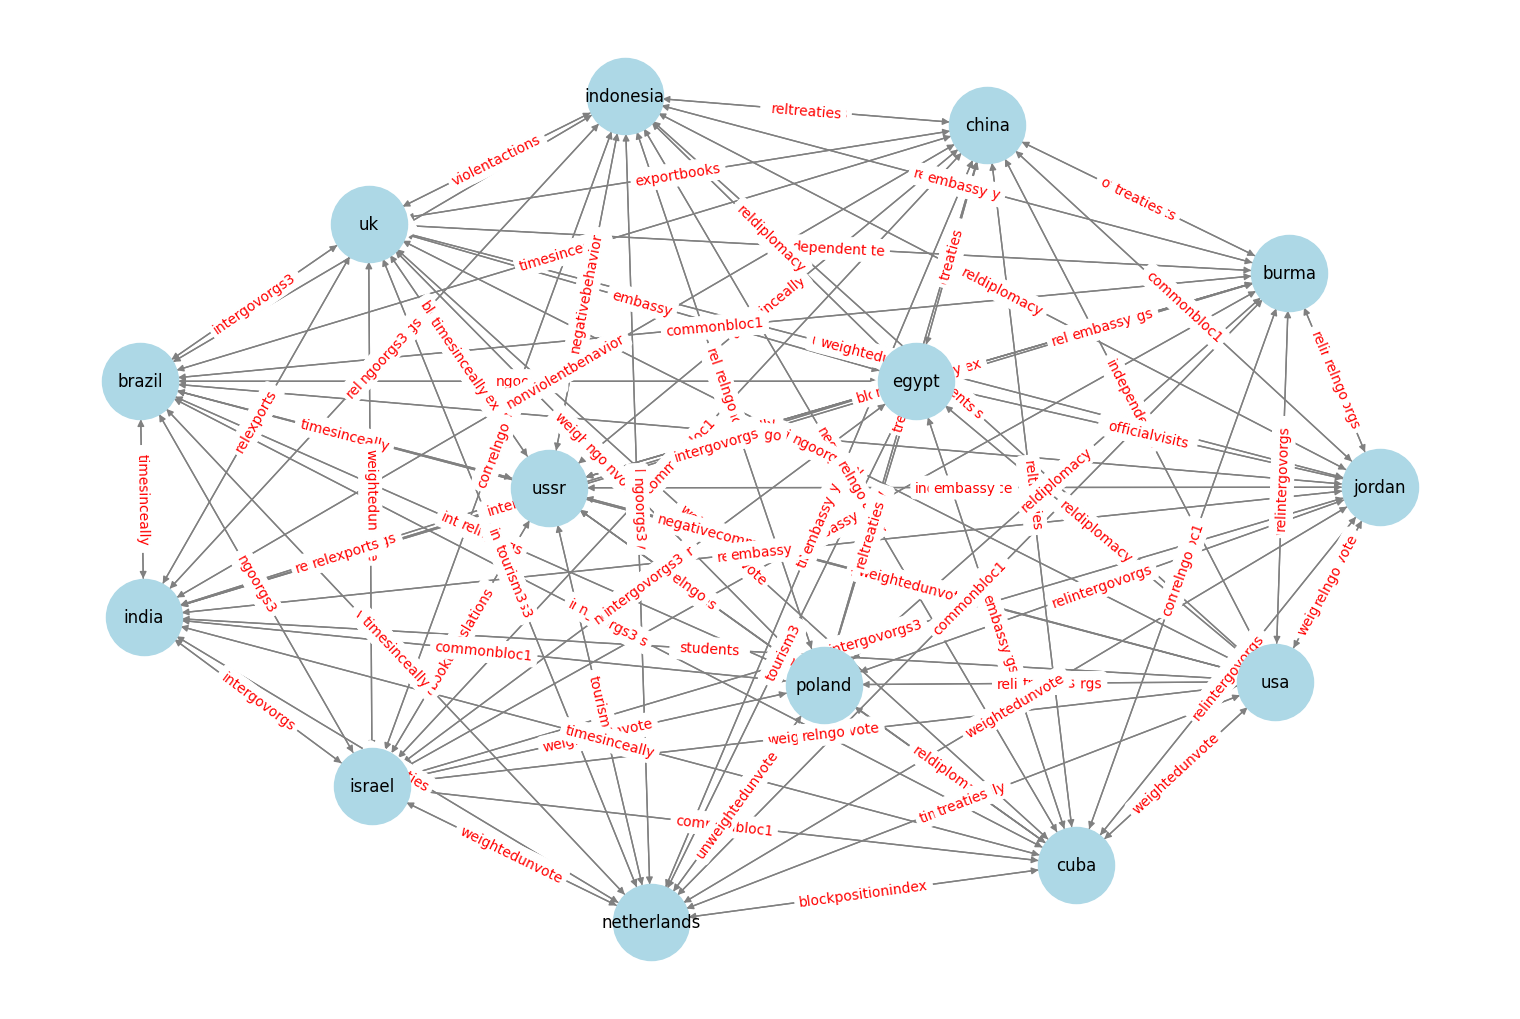

In [4]:
# Visualize the full KG

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph (each edge represents a triple)
for subj, pred, obj in all_triples:
    G.add_edge(subj, obj, label=pred)

# Position nodes using a layout algorithm (e.g., spring layout)
pos = nx.spring_layout(G, k=0.5, iterations=20)  # Adjusted layout parameters for larger graph

# Set the size of the Matplotlib figure
plt.figure(figsize=(15, 10))  # Width, Height in inches

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

# Show the plot
plt.show()

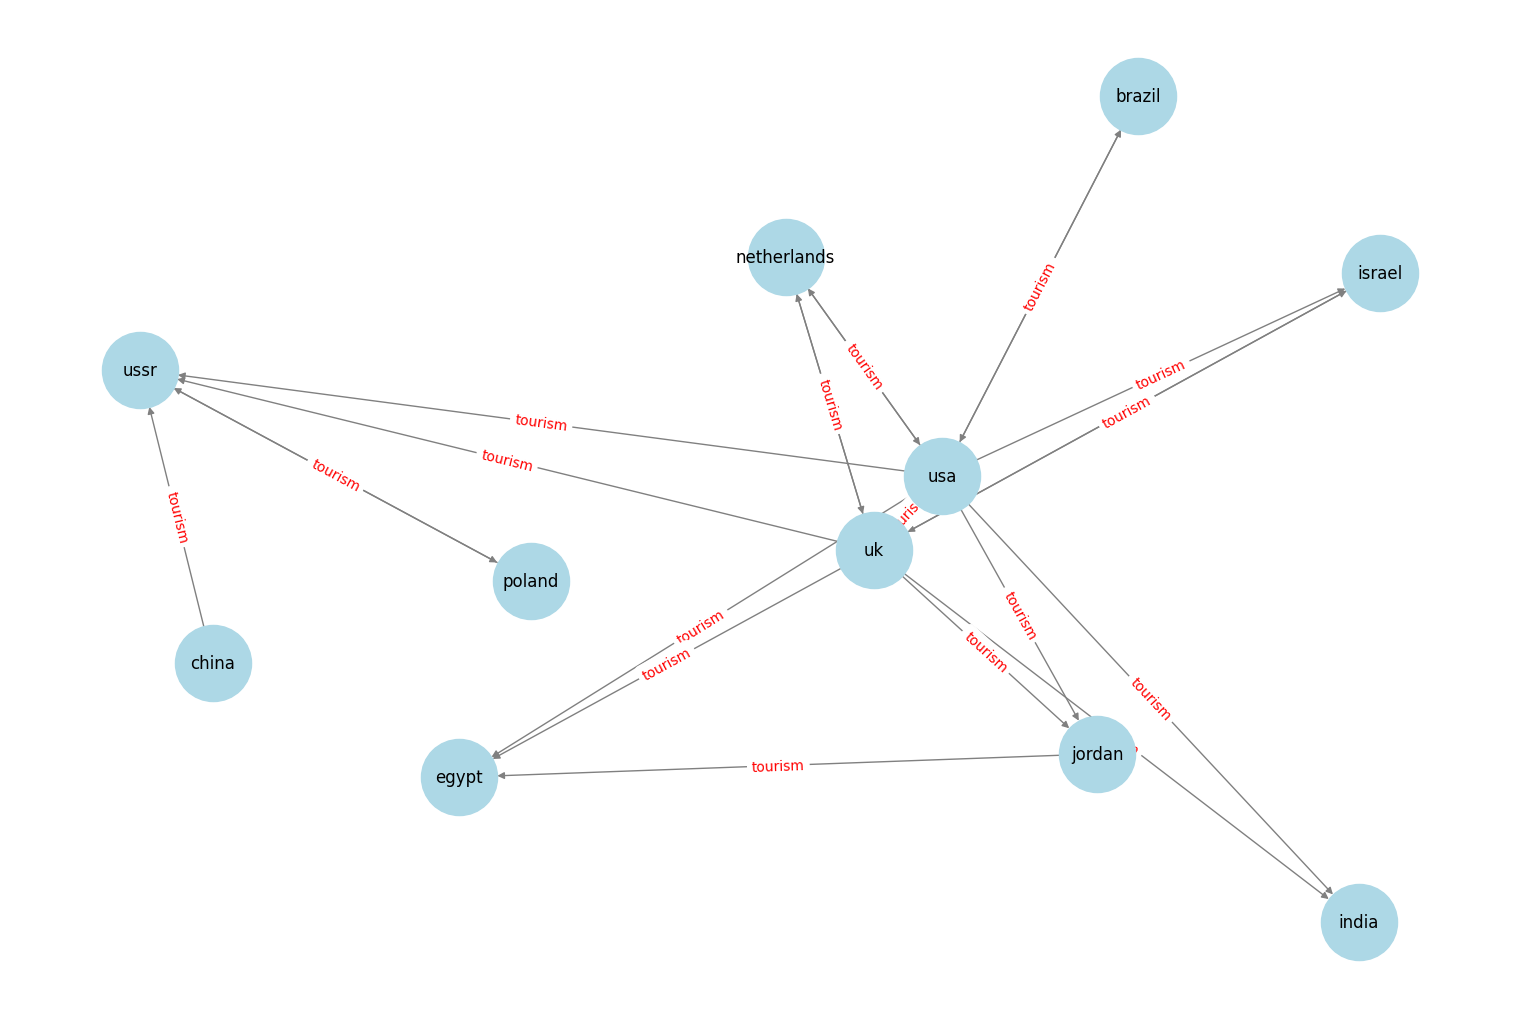

In [5]:
# Visualize the portion of the KG related to "tourism" relations

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph (only include "tourism" edges)
for subj, pred, obj in all_triples:
    if pred == 'tourism':
        G.add_edge(subj, obj, label=pred)

# Set a fixed seed for the layout to ensure reproducibility
seed = 42
pos = nx.spring_layout(G, k=0.5, iterations=20, seed=seed)

# Set the size of the Matplotlib figure
plt.figure(figsize=(15, 10))  # Width, Height in inches

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

# Show the plot
plt.show()

In [6]:
# Access the triples and preview a few of them
training_triples = dataset.training.mapped_triples
validation_triples = dataset.validation.mapped_triples
test_triples = dataset.testing.mapped_triples

print("Training Triples:\n", training_triples[:5])
print("Validation Triples:\n", validation_triples[:5])
print("Test Triples:\n", test_triples[:5])


# Access the 'tourism' triples and preview them
training_triples = dataset.training.triples
validation_triples = dataset.validation.triples
test_triples = dataset.testing.triples

print("\n\nTraining Triples with 'tourism' relationship:")
for triple in training_triples:
    if triple[1] == "tourism":
        print(triple)
print("\nValidation Triples with 'tourism' relationship:")
for triple in validation_triples:
    if triple[1] == "tourism":
        print(triple)
print("\nTest Triples with 'tourism' relationship:")
for triple in test_triples:
    if triple[1] == "tourism":
        print(triple)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


Training Triples:
 tensor([[ 0,  3,  2],
        [ 0,  3,  3],
        [ 0,  3, 10],
        [ 0,  3, 13],
        [ 0,  4, 11]])
Validation Triples:
 tensor([[ 0,  7,  6],
        [ 0,  9, 10],
        [ 0,  9, 11],
        [ 0, 14,  6],
        [ 0, 19, 10]])
Test Triples:
 tensor([[ 0,  7,  5],
        [ 0, 14, 11],
        [ 0, 18, 12],
        [ 0, 20,  3],
        [ 0, 20, 10]])


Training Triples with 'tourism' relationship:
['brazil' 'tourism' 'usa']
['china' 'tourism' 'ussr']
['israel' 'tourism' 'uk']
['jordan' 'tourism' 'egypt']
['netherlands' 'tourism' 'uk']
['netherlands' 'tourism' 'usa']
['poland' 'tourism' 'ussr']
['uk' 'tourism' 'egypt']
['uk' 'tourism' 'india']
['uk' 'tourism' 'israel']
['uk' 'tourism' 'jordan']
['uk' 'tourism' 'netherlands']
['uk' 'tourism' 'usa']
['uk' 'tourism' 'ussr']
['usa' 'tourism' 'brazil']
['usa' 'tourism' 'india']
['usa' 'tourism' 'israel']
['usa' 'tourism' 'jordan']
['usa' 'tourism' 'netherlands']
['usa' 'tourism' 'ussr']
['ussr' 'tourism' 'p

### Training phase

**TransE** is a simple and efficient knowledge graph embedding model that represents entities and relations in a continuous vector space. It models relationships as translations in the vector space. Given a triple
(
h
,
r
,
t
)
(h,r,t), where
h
h is the head entity,
r
r is the relation, and
t
t is the tail entity, TransE aims to ensure that the sum of the vector of the head entity and the relation is close to the vector of the tail entity:

h
+
r
≈
t

In [7]:
# Define the model - you can choose any other model from PyKeen
from pykeen.models import TransE
model = TransE(triples_factory=dataset.training)

No random seed is specified. This may lead to non-reproducible results.


Adam (Adaptive Moment Estimation) uses the concepts of the first and second moments to optimize neural network parameters. It estimates the first moment (mean) of the gradients to smooth updates and the second moment (variance) to adapt the learning rate based on the gradient's variability. By combining these, Adam adjusts the learning rate dynamically for each parameter, improving stability and convergence speed.

In [8]:
# Pick the optimizer: Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
optimizer=optim.Adam(params=model.get_grad_params())

SLCWA stands for Stochastic Local Closed World Assumption. It involves randomly selecting a subset of triples not present in the knowledge graph to treat as negative examples during training. This approach helps reduce computational effort and allows the model to handle negative samples more efficiently, improving training dynamics by focusing on a manageable number of negative examples. Negative examples are created by randomly altering parts of true triples (head, relation, or tail) to generate new triples that are assumed to be false.

In [9]:
# Pick a training approach,
#e.g., Stochastic Local Closed World Assumption (SLCWA), or Local Closed World Assumption (LCWA)
from pykeen.training import SLCWATrainingLoop

# Initialize the training loop with SLCWATrainingLoop
training_loop=SLCWATrainingLoop(model=model, optimizer=optimizer,triples_factory=dataset.training)

In [10]:
# Train the model, define epochs and batch size
training_loop.train(num_epochs=100, batch_size=64,triples_factory=dataset.training)

Training epochs on cpu: 100%|██████████| 100/100 [00:17<00:00,  5.77epoch/s, loss=0.651, prev_loss=0.639]


[1.4305169343948365,
 1.3459626340866089,
 1.2890683221817016,
 1.2753969526290894,
 1.2164932584762573,
 1.1870568346977235,
 1.1662600827217102,
 1.1504404997825624,
 1.1821845412254333,
 1.0986106562614442,
 1.034312491416931,
 1.0202199268341063,
 1.0450395512580872,
 1.0260024380683899,
 0.9716978287696838,
 0.9901834082603455,
 0.9720629024505615,
 0.9528422617912292,
 0.9284147715568543,
 0.9546418023109436,
 0.9200731539726257,
 0.9080805277824402,
 0.946681911945343,
 0.8552607727050782,
 0.8792551565170288,
 0.9008373284339904,
 0.8650835251808167,
 0.8636519861221313,
 0.8217014527320862,
 0.836356885433197,
 0.8489481139183045,
 0.8280730271339416,
 0.8295959448814392,
 0.8418753790855408,
 0.7956654620170593,
 0.8479263830184937,
 0.7725164341926575,
 0.8068059301376342,
 0.7655626010894775,
 0.7953851056098938,
 0.799240140914917,
 0.8001251196861268,
 0.7707943463325501,
 0.7721259260177612,
 0.7865073800086975,
 0.7890796947479248,
 0.7594438743591309,
 0.76178412079811

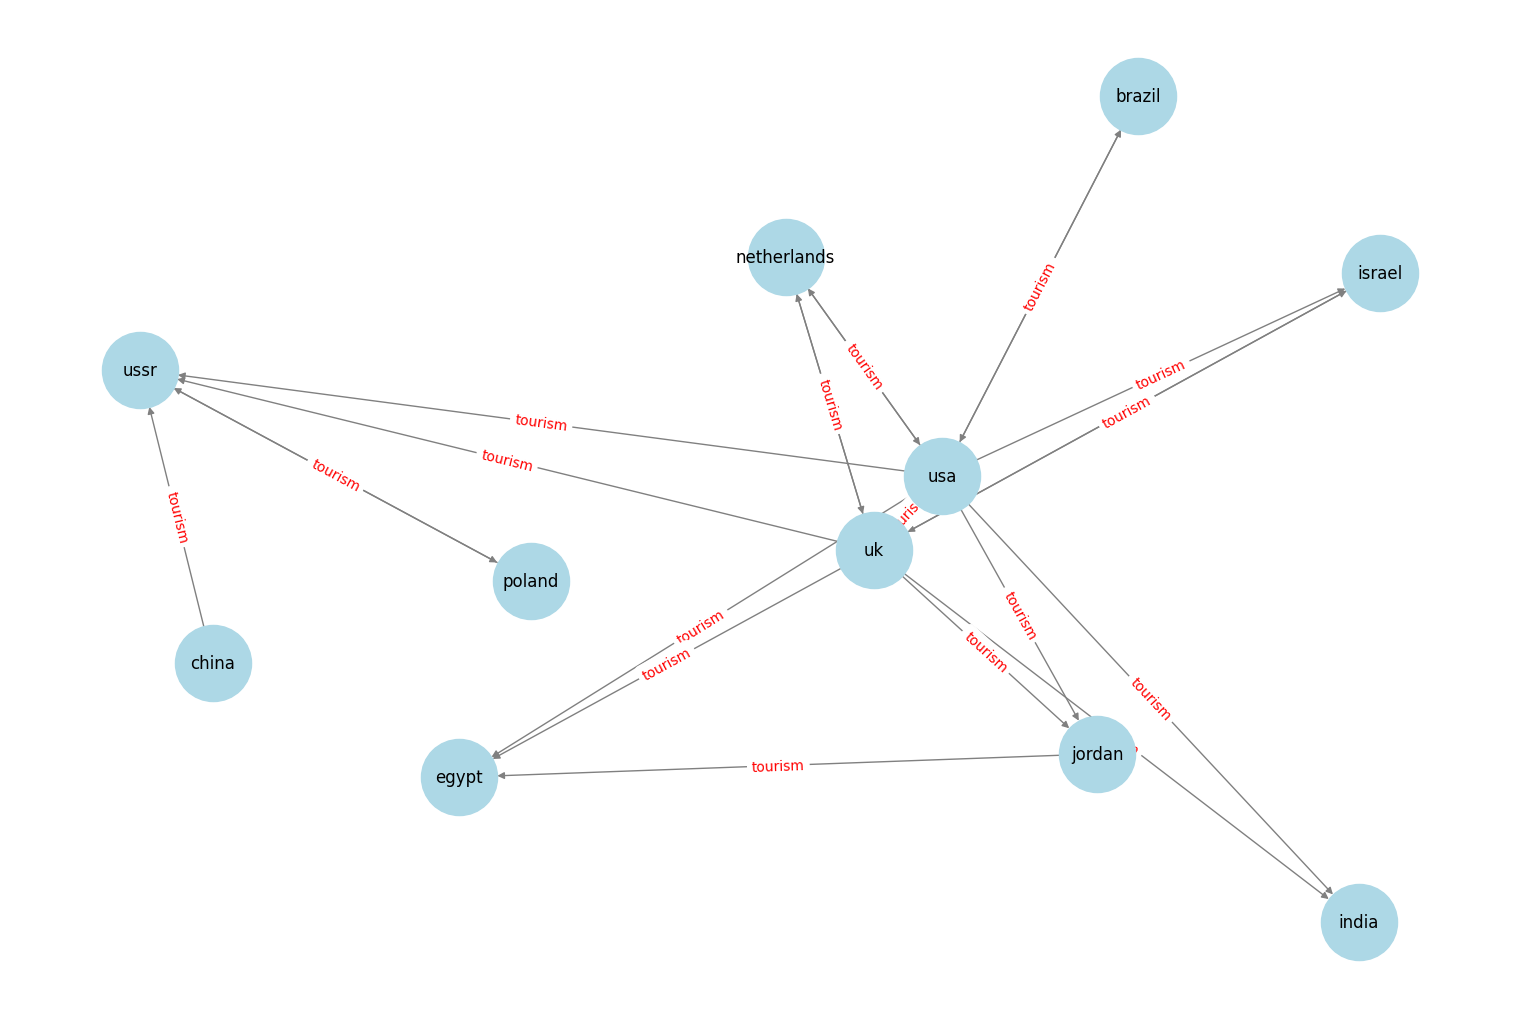

In [11]:
# Visualize the KG for "tourism" edges after training

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph (only include "tourism" edges)
for subj, pred, obj in all_triples:
    if pred == 'tourism':
        G.add_edge(subj, obj, label=pred)

# Set a fixed seed for the layout to ensure reproducibility
seed = 42
pos = nx.spring_layout(G, k=0.5, iterations=20, seed=seed)  # Fixed seed for reproducibility

# Set the size of the Matplotlib figure
plt.figure(figsize=(15, 10))  # Width, Height in inches

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

# Show the plot
plt.show()

### Evaluation phase

In [12]:
# Pick an evaluator
from pykeen.evaluation import RankBasedEvaluator
evaluator = RankBasedEvaluator()

In [13]:
# Evaluate on validation set during training
mapped_triples_validation = dataset.validation.mapped_triples
validation_results = evaluator.evaluate(model,
                                        mapped_triples_validation,
                                        batch_size=1024)

print("Validation Results:\n", validation_results)

The filtered setting was enabled, but there were no `additional_filter_triples`
given. This means you probably forgot to pass (at least) the training triples. Try:

    additional_filter_triples=[dataset.training.mapped_triples]

Or if you want to use the Bordes et al. (2013) approach to filtering, do:

    additional_filter_triples=[
        dataset.training.mapped_triples,
        dataset.validation.mapped_triples,
    ]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 199/199 [00:00<00:00, 4.13ktriple/s]

Validation Results:



RankBasedEvaluator is a tool used to evaluate the performance of knowledge graph embedding models by ranking predictions and measuring their quality against ground truth data. It assesses how well a model predicts the correct tail or head entity for a given (head, relation) or (relation, tail) pair.

Ranking: For a given query (e.g.,
(
h
,
r
,
?
)
(h,r,?) or
(
?
,
r
,
t
)
(?,r,t)), the model predicts scores for all possible entities. These entities are ranked based on their predicted scores.

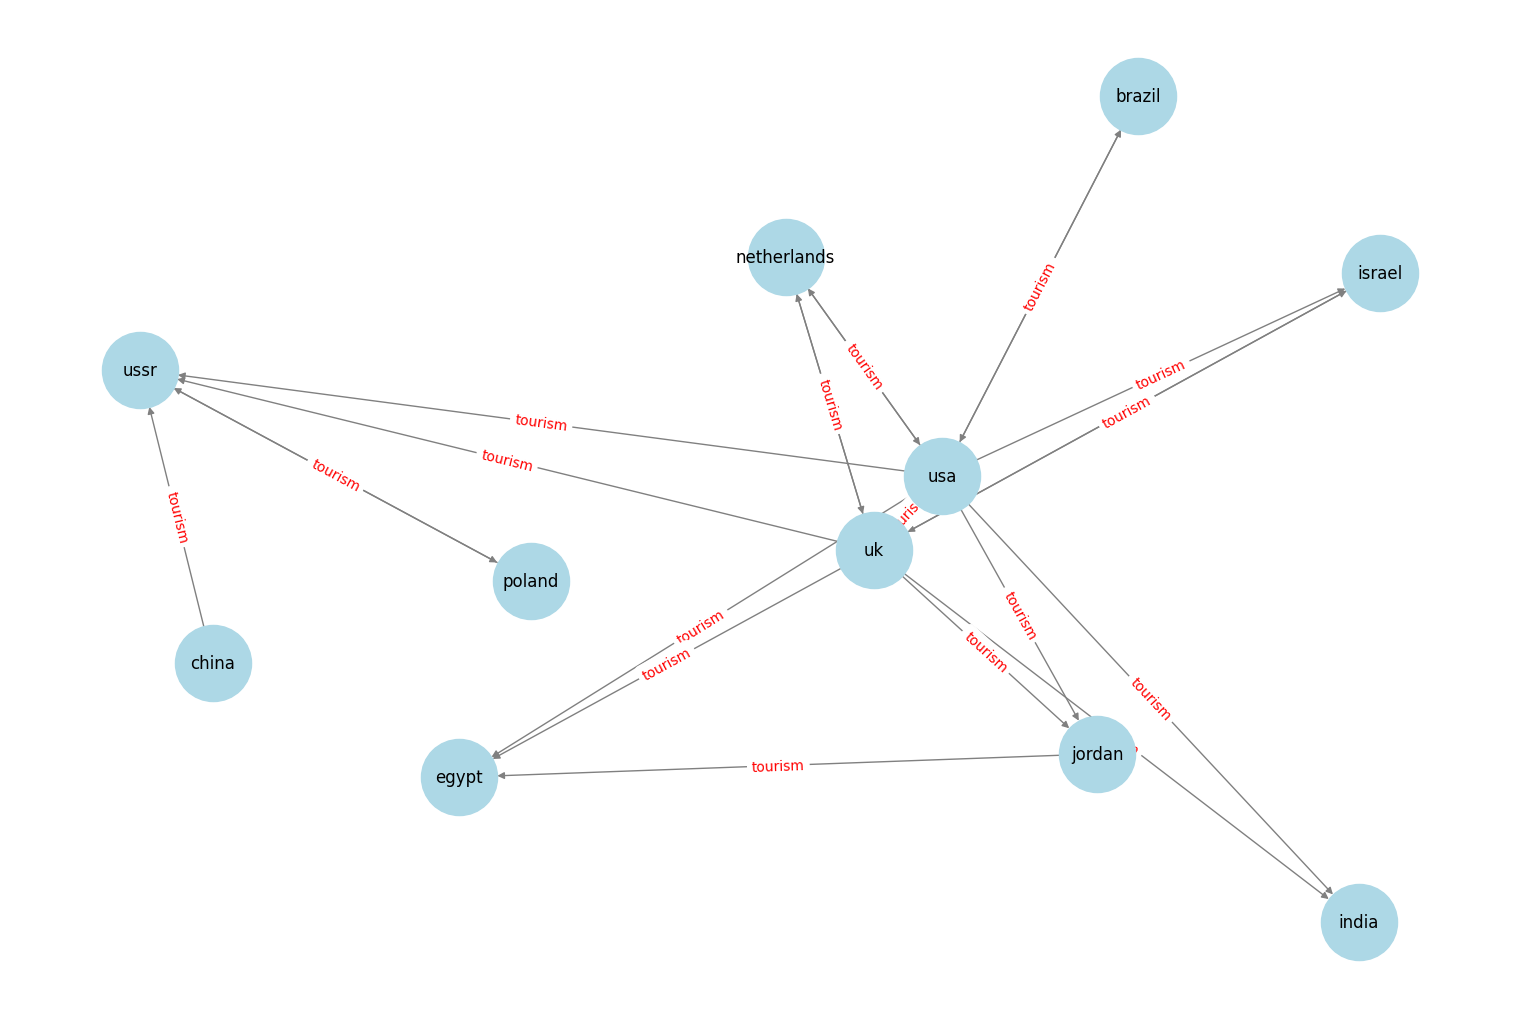

In [14]:
# Visualize the KG for "tourism" edges after evaluation

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph (only include "tourism" edges)
for subj, pred, obj in all_triples:
    if pred == 'tourism':
        G.add_edge(subj, obj, label=pred)

# Set a fixed seed for the layout to ensure reproducibility
seed = 42
pos = nx.spring_layout(G, k=0.5, iterations=20, seed=seed)  # Fixed seed for reproducibility

# Set the size of the Matplotlib figure
plt.figure(figsize=(15, 10))  # Width, Height in inches

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

# Show the plot
plt.show()

### Prediction phase

In [15]:
from pykeen.predict import predict_target


In [16]:
pred_usa = predict_target(
    model=model,
    head="usa",
    relation="tourism",
    triples_factory=dataset.training,
 )

In [17]:
pred_usa

TargetPredictions(df=    tail_id     score   tail_label
12       12 -6.577297          usa
9         9 -7.013031  netherlands
5         5 -7.102723        india
11       11 -7.197950           uk
8         8 -7.334091       jordan
13       13 -7.454744         ussr
7         7 -7.499152       israel
0         0 -7.941239       brazil
6         6 -8.126314    indonesia
4         4 -8.242291        egypt
10       10 -8.347652       poland
3         3 -8.752501         cuba
2         2 -9.055819        china
1         1 -9.184112        burma, factory=TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/usr/local/lib/python3.11/site-packages/pykeen/datasets/nations/train.txt"), target='tail', other_columns_fixed_ids=(12, 47))

In [18]:
pred_usa_filtered = pred_usa.filter_triples(dataset.training)
pred_usa_filtered

TargetPredictions(df=    tail_id     score tail_label
12       12 -6.577297        usa
11       11 -7.197950         uk
6         6 -8.126314  indonesia
4         4 -8.242291      egypt
10       10 -8.347652     poland
3         3 -8.752501       cuba
2         2 -9.055819      china
1         1 -9.184112      burma, factory=TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/usr/local/lib/python3.11/site-packages/pykeen/datasets/nations/train.txt"), target='tail', other_columns_fixed_ids=(12, 47))

In [19]:
pred_netherlands = predict_target(
    model=model,
    head="netherlands",
    relation="tourism",
     triples_factory=dataset.training,
 )

In [20]:
pred_netherlands_filtered = pred_netherlands.filter_triples(dataset.training)
pred_netherlands_filtered

TargetPredictions(df=    tail_id     score   tail_label
9         9 -6.577297  netherlands
5         5 -8.129851        india
13       13 -8.241199         ussr
7         7 -8.357798       israel
8         8 -8.721249       jordan
10       10 -8.723767       poland
0         0 -8.879822       brazil
4         4 -9.004091        egypt
6         6 -9.341841    indonesia
3         3 -9.393668         cuba
2         2 -9.532152        china
1         1 -9.791009        burma, factory=TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/usr/local/lib/python3.11/site-packages/pykeen/datasets/nations/train.txt"), target='tail', other_columns_fixed_ids=(9, 47))

In [21]:
pred_india = predict_target(
    model=model,
    head="india",
    relation="tourism",
     triples_factory=dataset.training,
 )

In [22]:
pred_india_filtered = pred_india.filter_triples(dataset.training)
pred_india_filtered

TargetPredictions(df=    tail_id      score   tail_label
5         5  -6.577297        india
8         8  -8.122303       jordan
12       12  -8.340529          usa
13       13  -8.522536         ussr
11       11  -8.558311           uk
6         6  -8.939139    indonesia
1         1  -8.994628        burma
10       10  -9.015568       poland
4         4  -9.056082        egypt
9         9  -9.082854  netherlands
7         7  -9.195814       israel
0         0  -9.331430       brazil
2         2  -9.560738        china
3         3 -10.220717         cuba, factory=TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/usr/local/lib/python3.11/site-packages/pykeen/datasets/nations/train.txt"), target='tail', other_columns_fixed_ids=(5, 47))

In [23]:
# Define score threshold
score_threshold = -8.5
pred_india_filtered_df = pred_india_filtered.df
pred_usa_filtered_df = pred_usa_filtered.df
pred_netherlands_filtered_df = pred_netherlands_filtered.df
# Get filtered predictions
predicted_tails_india_filtered_with_threshold = pred_india_filtered_df[pred_india_filtered_df['score'] >= score_threshold]
predicted_tails_usa_filtered_with_threshold = pred_usa_filtered_df[pred_usa_filtered_df['score'] >= score_threshold]
predicted_tails_neitherlands_filtered_with_threshold = pred_netherlands_filtered_df[pred_netherlands_filtered_df['score'] >= score_threshold]

print("Filtered tourism predictions for India:")
print(predicted_tails_india_filtered_with_threshold)
print("\nFiltered tourism predictions for USA:")
print(predicted_tails_usa_filtered_with_threshold)
print("\nFiltered tourism predictions for Netherlands:")
print(predicted_tails_neitherlands_filtered_with_threshold)

Filtered tourism predictions for India:
    tail_id     score tail_label
5         5 -6.577297      india
8         8 -8.122303     jordan
12       12 -8.340529        usa

Filtered tourism predictions for USA:
    tail_id     score tail_label
12       12 -6.577297        usa
11       11 -7.197950         uk
6         6 -8.126314  indonesia
4         4 -8.242291      egypt
10       10 -8.347652     poland

Filtered tourism predictions for Netherlands:
    tail_id     score   tail_label
9         9 -6.577297  netherlands
5         5 -8.129851        india
13       13 -8.241199         ussr
7         7 -8.357798       israel


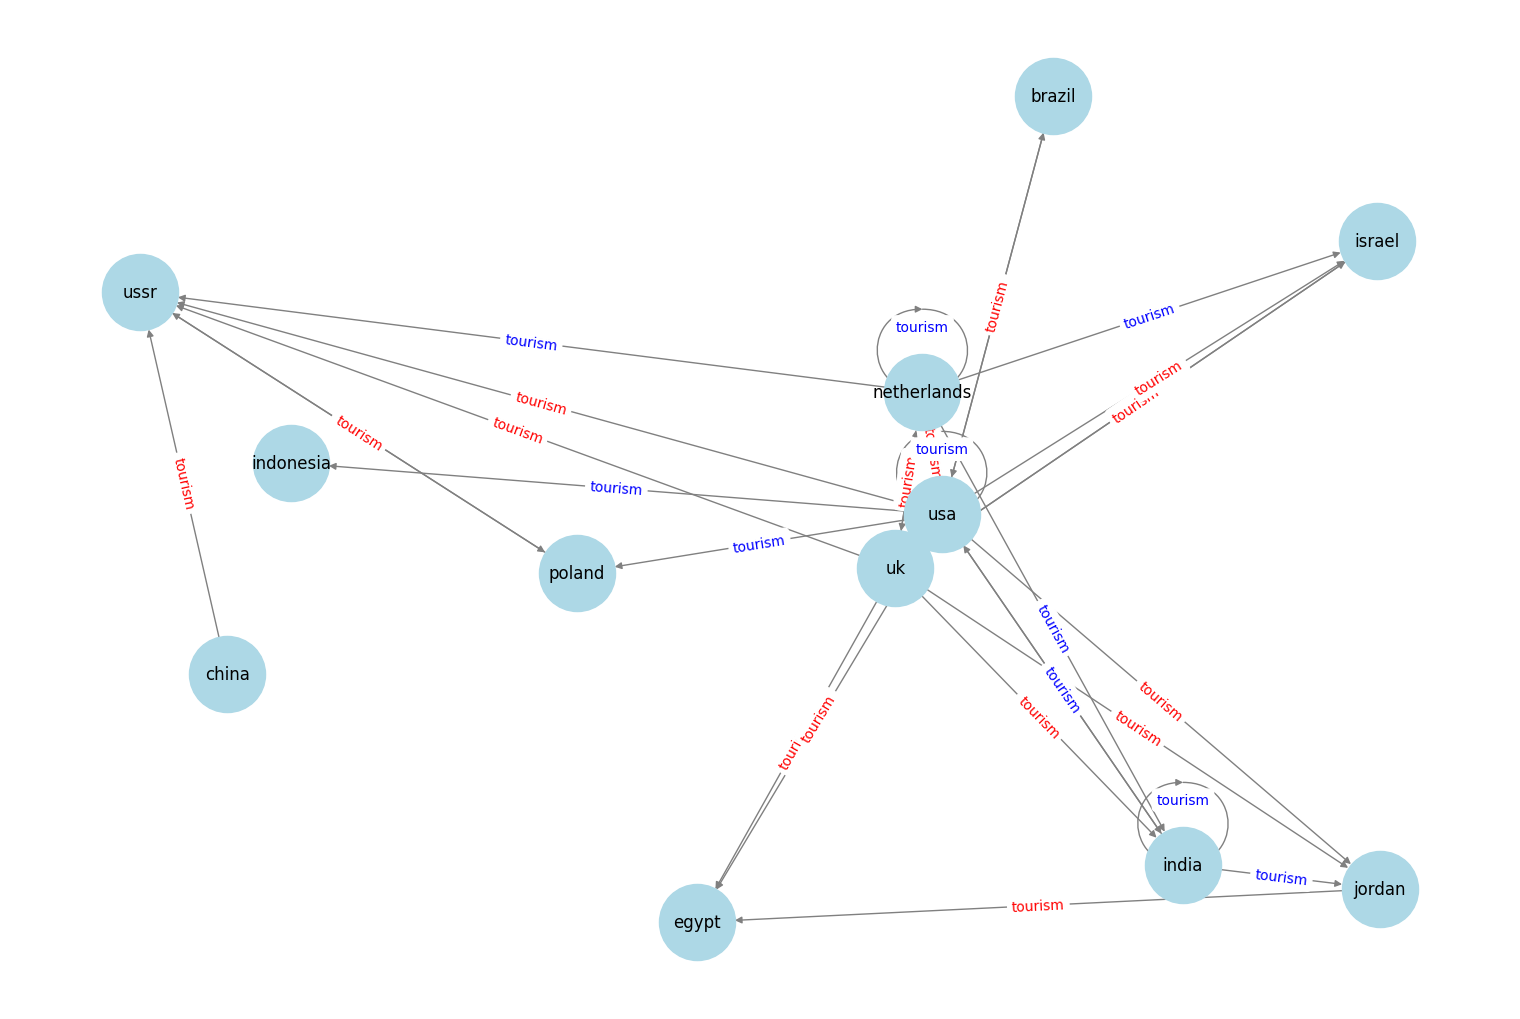

In [24]:
# Extract the new predicted filtered triples (head, relation, tail) that are not in the training set
new_triples = []
new_triples += [('india', 'tourism', row['tail_label']) for _, row in predicted_tails_india_filtered_with_threshold.iterrows()]
new_triples += [('usa', 'tourism', row['tail_label']) for _, row in predicted_tails_usa_filtered_with_threshold.iterrows()]
new_triples += [('netherlands', 'tourism', row['tail_label']) for _, row in predicted_tails_neitherlands_filtered_with_threshold.iterrows()]

# Visualize the KG for "tourism" edges after adding predictions

# Create a directed graph
G = nx.DiGraph()

# Add existing "tourism" edges to the graph
existing_edges = []
for subj, pred, obj in all_triples:
    if pred == 'tourism':
        G.add_edge(subj, obj, label=pred)
        existing_edges.append((subj, obj))

# Add new predicted edges to the graph only if they are not already present
new_edges = []
for subj, pred, obj in new_triples:
    if (subj, obj) not in existing_edges:
        G.add_edge(subj, obj, label=pred)
        new_edges.append((subj, obj))

# Set a fixed seed for the layout to ensure reproducibility
seed = 42
pos = nx.spring_layout(G, k=0.5, iterations=20, seed=seed)  # Fixed seed for reproducibility

# Set the size of the Matplotlib figure
plt.figure(figsize=(15, 10))  # Width, Height in inches

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12)

# Draw existing edge labels
existing_edge_labels = {edge: 'tourism' for edge in existing_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=existing_edge_labels, font_color='red', font_size=10)

# Draw new edge labels with a different color
new_edge_labels = {edge: 'tourism' for edge in new_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=new_edge_labels, font_color='blue', font_size=10)

# Show the plot
plt.show()

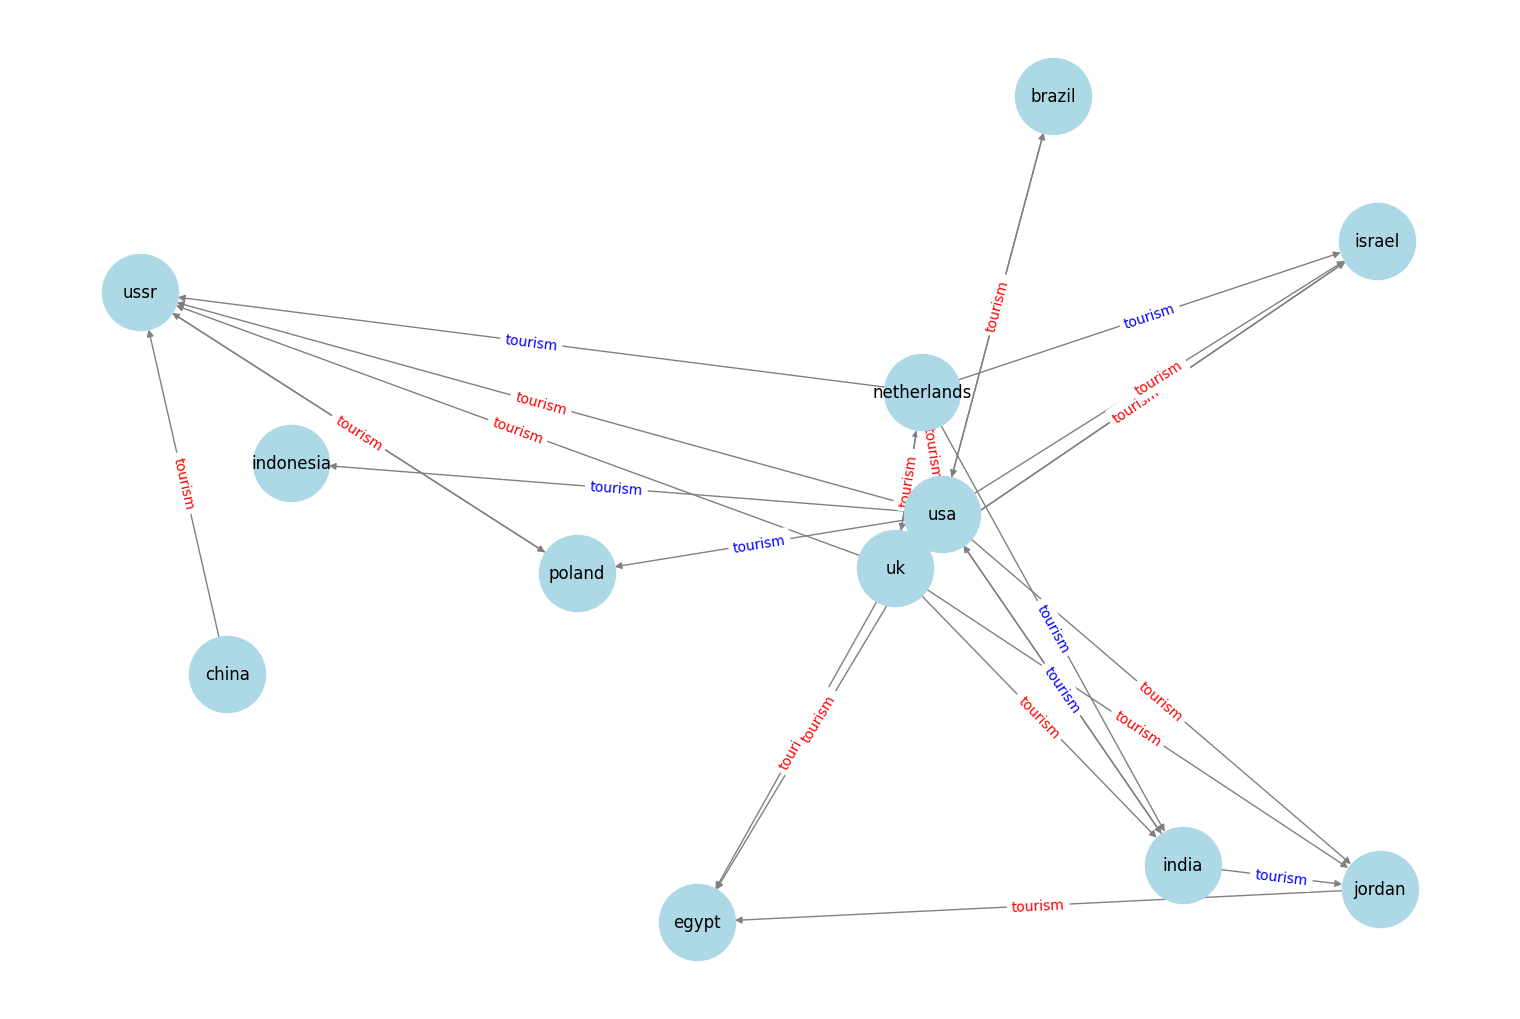

In [25]:
# Extract the new predicted filtered triples (head, relation, tail) that are not in the training set
new_triples = []
# Add filtered triples only if head and tail are different (i.e., excluding domestic tourism)
new_triples += [('india', 'tourism', row['tail_label']) for _, row in predicted_tails_india_filtered_with_threshold.iterrows() if row['tail_label'] != 'india']
new_triples += [('usa', 'tourism', row['tail_label']) for _, row in predicted_tails_usa_filtered_with_threshold.iterrows() if row['tail_label'] != 'usa']
new_triples += [('netherlands', 'tourism', row['tail_label']) for _, row in predicted_tails_neitherlands_filtered_with_threshold.iterrows() if row['tail_label'] != 'netherlands']

# Visualize the KG for "tourism" edges after adding predictions

# Create a directed graph
G = nx.DiGraph()

# Add existing "tourism" edges to the graph
existing_edges = []
for subj, pred, obj in all_triples:
    if pred == 'tourism':
        G.add_edge(subj, obj, label=pred)
        existing_edges.append((subj, obj))

# Add new predicted edges to the graph only if they are not already present and exclude internal tourism
new_edges = []
for subj, pred, obj in new_triples:
    if (subj, obj) not in existing_edges:
        G.add_edge(subj, obj, label=pred)
        new_edges.append((subj, obj))

# Set a fixed seed for the layout to ensure reproducibility
seed = 42
pos = nx.spring_layout(G, k=0.5, iterations=20, seed=seed)  # Fixed seed for reproducibility

# Set the size of the Matplotlib figure
plt.figure(figsize=(15, 10))  # Width, Height in inches

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12)

# Draw existing edge labels
existing_edge_labels = {edge: 'tourism' for edge in existing_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=existing_edge_labels, font_color='red', font_size=10)

# Draw new edge labels with a different color
new_edge_labels = {edge: 'tourism' for edge in new_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=new_edge_labels, font_color='blue', font_size=10)

# Show the plot
plt.show()
